In [59]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val*180/np.pi

In [74]:
def output(sim, time,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2):
    ps = sim.particles
    for p in planets:
        try:
            e[p].append(ps[p].e)
            P[p].append(ps[p].P)
            pomega[p].append(ps[p].pomega)
            longitude[p].append(ps[p].l)  
            t[p].append(time)
        except:
            pass
    for resonance in resonances.items():
        pair = resonance[0]
        p1 = pair[0]
        p2 = pair[1]
        res = resonance[1]
        p = res[1]
        q = res[0]-res[1]
        try:
            Pratio[pair].append(ps[p2].P/ps[p1].P)
            phi1[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p2].pomega))
            phi2[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p1].pomega))
            t[pair].append(time)   
        except:
            pass
            
def add_into_resonance(sim, resonance, planets, resonances, mass, taue, e0, K, t, e, P, pomega, longitude, Pratio, phi1, phi2):
    ps = sim.particles
    pair = resonance[0]
    p1 = pair[0]
    p2 = pair[1]
    res = resonance[1]
    p = res[1]
    q = res[0]-res[1]
    
    delta=2.e-2 # fractional distance to start beyond resonance. Would be better to calculate relative to width of resonance

    sim.add(m=mass,P=(p+q)/p*sim.particles[-1].P*(1.+delta), e=e0, l=np.pi, hash=p2)
    sim.move_to_com() # Moves to the center of momentum frame
    
    taua = K*taue
    T = taua*delta*3 # have buffer to reach resonance and evolve after
    ps[-1].params["tau_a"] = -taua
    ps[-1].params["tau_e"] = -taue
    ps[-2].params["tau_e"] = -taue 

    Nout = 1000
    T0 = sim.t
    times = np.linspace(T0,T0+T,Nout)
    
    for i, time in enumerate(times):
        sim.integrate(time)
        output(sim,time,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2)

In [75]:
def plot(t,P,e,Pratio,phi1,phi2,planets,resonances):
    fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=(18,10))
    for p in planets:
        axarr[0,0].plot(t[p], P[p], '.', label=p)
        axarr[0,1].plot(t[p], e[p], '.', label=p)
    for resonance in resonances.items():
        pair = resonance[0]
        res = resonance[1]
        resratio = res[0]/res[1]
        axarr[1,0].plot(t[pair], Pratio[pair], '.', label=pair)
        axarr[1,1].plot(t[pair], np.array(Pratio[pair])-resratio, '.', label=pair)
        axarr[2,0].plot(t[pair], phi1[pair], '.', label=pair)
        axarr[2,1].plot(t[pair], phi2[pair], '.', label=pair)
        axarr[2,0].set_ylim([0.,360])
        axarr[2,1].set_ylim([0.,360])
    for ax in axarr.flatten():
        ax.legend(loc='upper left')
    return fig

In [76]:
def removedamping(sim, Tremoval, K, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances): # Tremovel in # of taue0s
    ps = sim.particles
    taue0 = ps[-1].params["tau_e"]
    T0 = sim.t
    print(T0)
    T = abs(taue0)*Tremoval
    Nout = 1000
    times = np.linspace(T0, T0+T, Nout)
    
    for i, time in enumerate(times):
        for p in ps[1:]:
            p.params["tau_e"] = taue0/(1.-(sim.t-T0)/T)
            try: # try except so we don't assign a tau_a to planets that don't have it
                has_tau_a = p.params["tau_a"]
                p.params["tau_a"] = taue0*K/(1.-(sim.t-T0)/T)
            except:
                pass
        sim.integrate(time)
        output(sim,time,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2)
        
    for p in ps[1:]:
        p.params["tau_e"] = np.inf
        p.params["tau_a"] = np.inf

def integrate(sim, T, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances):
    Nout = 1000
    T0 = sim.t
    times = np.linspace(T0, T0+T, Nout)
    ps = sim.particles
    for i, time in enumerate(times):
        sim.integrate(time)
        output(sim,time,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2)
        
def initialize(planets, resonances):
    t, e, P, pomega, longitude, Pratio, phi1, phi2 = {}, {}, {}, {}, {}, {}, {}, {}

    for label in planets:
        t[label] = []
        e[label] = []
        P[label] = []
        pomega[label] = []
        longitude[label] = []

    for pair in resonances.keys():
        t[pair] = []
        Pratio[pair] = []
        phi1[pair] = []
        phi2[pair] = []
        
    return t, e, P, pomega, longitude, Pratio, phi1, phi2

In [77]:
def rescale(sim, planets, Mstar, aouter):
    mscale = Mstar/sim.particles[0].m
    xscale = aouter/sim.particles[-1].a
    sim2 = rebound.Simulation()
    sim2.G = 4*np.pi**2
    sim2.add(m=sim.particles[0].m*mscale)
    for p in planets:
        p1 = sim.particles[p]
        sim2.add(m=p1.m*mscale, a=p1.a*xscale, e=p1.e, inc=p1.inc, pomega=p1.pomega, Omega=p1.Omega, theta=p1.theta, hash=p)
        
    sim2.integrator="whfast"
    sim2.dt=sim2.particles[1].P*0.03

    return sim2

In [78]:
ab = 11.11/21.44 # scaled to d
ac = 15.21/21.44

mass = 5.e-5
e0 = 0.
planets = ['b', 'c', 'd', 'e', 'f', 'g']
resonances = OrderedDict([(('d','e'),(3,2)),(('e','f'),(3,2)),(('f','g'),(4,3))]) # ordered so we add planets in right sequence

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=mass, a=ab, e=e0, hash='b')
sim.add(m=mass, a=ac, e=e0, hash='c')

taue = 1.e4     
K = 100

rebx = reboundx.Extras(sim)
params = rebx.add("modify_orbits_forces")
ps = sim.particles

ps[1].params["tau_e"] = -taue
ps[2].params["tau_e"] = -taue

sim.add(m=mass ,a=1., e=e0, hash='d')

sim.integrator="whfast"
sim.dt=ps[1].P/20.

t, e, P, pomega, longitude, Pratio, phi1, phi2 = initialize(planets, resonances)

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


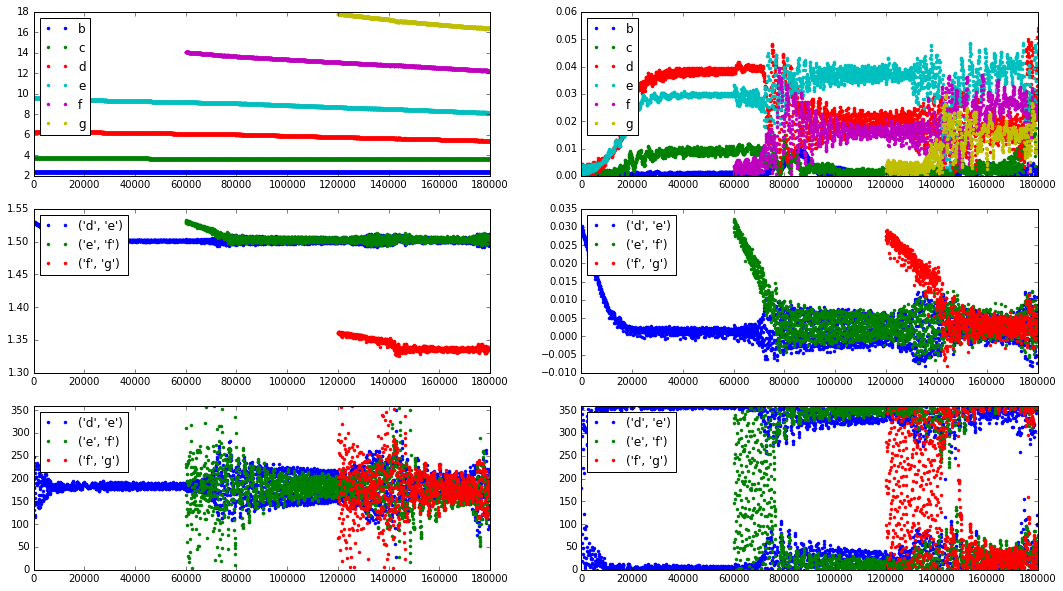

In [79]:
for resonance in resonances.items():
    add_into_resonance(sim, resonance, planets, resonances, mass, taue, e0, K, t, e, P, pomega, longitude, Pratio, phi1, phi2)

plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


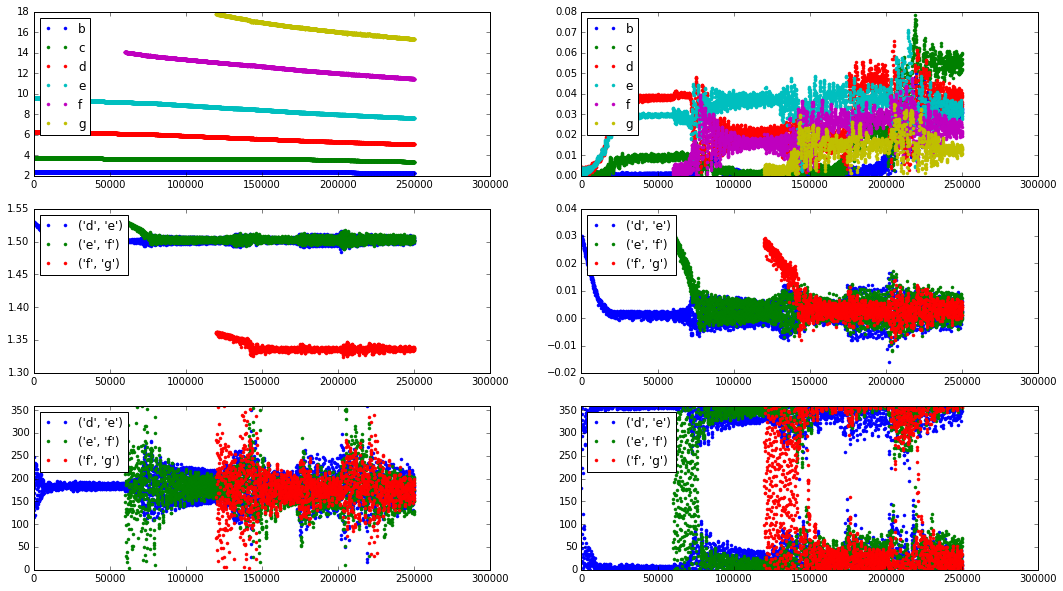

In [80]:
integrate(sim, 3.e4*sim.particles[1].P, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances)
plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

250238.42525690875


/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


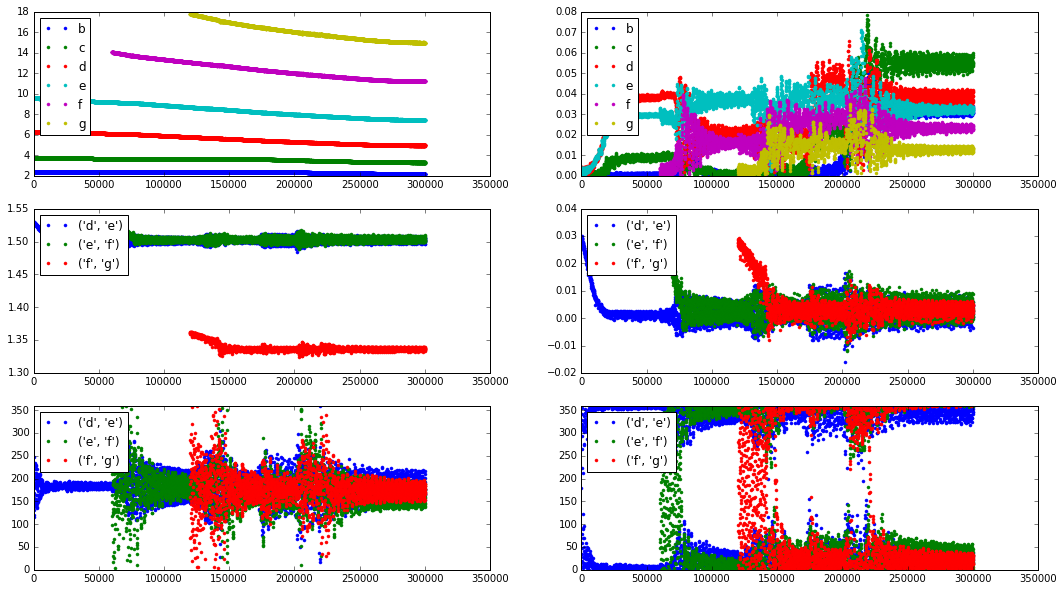

In [81]:
Tremoval = 5 # number of taue0s over which to remove damping
removedamping(sim, Tremoval, K, t, e, P, pomega, longitude, Pratio, phi1, phi2,planets,resonances)
plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 11.2 s


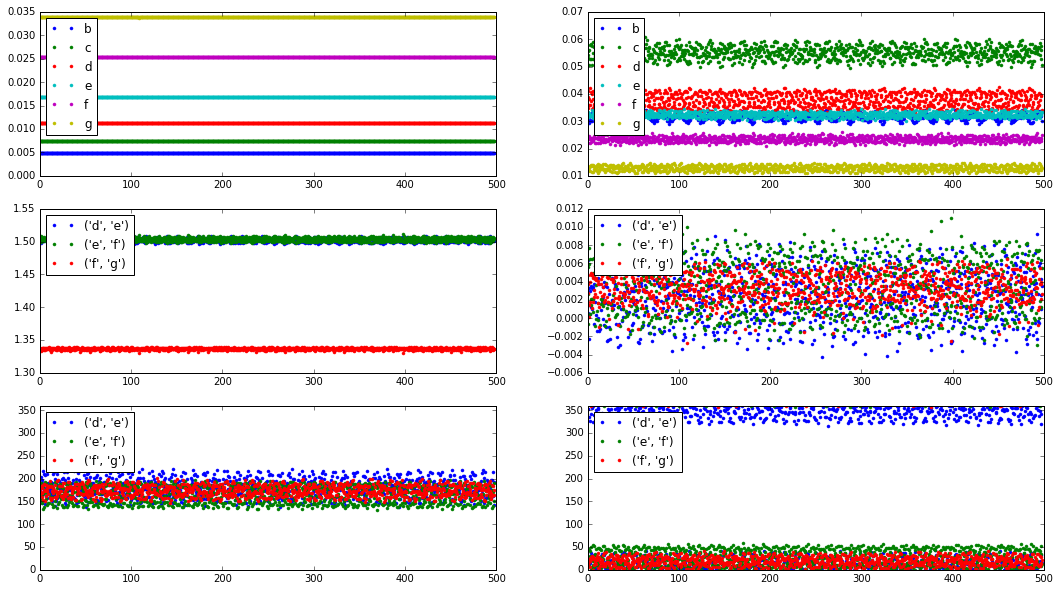

In [82]:
%%time
sim2 = rescale(sim, planets, Mstar=0.08, aouter=0.0451)

t, e, P, pomega, longitude, Pratio, phi1, phi2 = initialize(planets, resonances)
    
integrate(sim2, 1.e5*sim2.particles[1].P, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances)
plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

In [40]:
sim = rescale(sim, planets, Mstar=0.08, aouter=0.0451)
sim.save("data/bcnonres.bin")

In [100]:
import rebound
import reboundx
import numpy as np

def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

def run(taue0, tmax):
    sim = rebound.Simulation.from_file("data/4res.bin")
    ps = sim.particles

    sim.collision = "direct"
    sim.collision_resolve = collision
    sim.ri_whfast.safe_mode = 0

    minmass = 1.e10
    for p in ps[1:]:
        if p.m < minmass:
            minmass = p.m
    minhill = ps[1].a*(2.*minmass/(3.*ps[0].m))**(1./3.)
    for p in ps[1:]:
        p.r = minhill

    rebx = reboundx.Extras(sim)
    rebx.add("tides_synchronous_ecc_damping")

    aref = ps[1].a
    mref = ps[1].m
    for p in ps[1:]:
        p.params["tides_synchronous_tau_e"] = -taue0*(p.m/mref)*(p.a/aref)**6.5

    rebx.save("data/4resrebx"+"{0:.2e}".format(taue0)+".bin")
    sim.initSimulationArchive("data/4resarchive"+"{0:.2e}".format(taue0)+".bin", interval=tmax/1000.)
    sim.integrate(tmax)

In [113]:
%%time
tmax = ps[1].P*1.e6
run(1.e5,tmax)

CPU times: user 1min 22s, sys: 303 ms, total: 1min 23s
Wall time: 1min 25s


/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


In [110]:
ps[1].P*1.e6

11205.079225206897

In [3]:
import rebound
import reboundx
taue0 = 1.e5
tmax = 5.e2
sa = rebound.SimulationArchive("data/4resarchive"+"{0:.2e}".format(taue0)+".bin", rebxfilename = "data/4resrebx"+"{0:.2e}".format(taue0)+".bin")

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
def plotsa(sa,resonances,labels):
    Nout = len(sa)
    N = sa[0].N
    t, P, e, Pratio, dP, phi1, phi2 = np.zeros(Nout), np.zeros((N,Nout)), np.zeros((N,Nout)), np.zeros((N,Nout)), np.zeros((N,Nout)), np.zeros((N,Nout)), np.zeros((N,Nout)), 
    for i,sim in enumerate(sa):
        ps = sim.particles
        t[i] = sim.t
        for j in range(1,sim.N):
            P[j][i] = ps[j].P
            e[j][i] = ps[j].e
        for j in range(1,sim.N-1):
            Pratio[j][i] = ps[j+1].P/ps[j].P
            res = resonances[j-1]
            p = res[1]
            q = res[0]-res[1]
            resratio = (p+q)/p
            dP[j][i] = Pratio[j][i] - resratio
            phi1[j][i] = wrap((p+q)*ps[j+1].l - p*ps[j].l - q*ps[j+1].pomega)
            phi2[j][i] = wrap((p+q)*ps[j+1].l - p*ps[j].l - q*ps[j].pomega)
        
    fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=(18,10))
    for j in range(1,sim.N):
        axarr[0,0].plot(t, P[j], '.', label=labels[j])
        axarr[0,1].plot(t, e[j], '.', label=labels[j])
    
    for j in range(1,sim.N-1):
        res = resonances[j-1]
        resratio = res[0]/res[1]
        axarr[1,0].plot(t, Pratio[j], '.', label=labels[j+1]+":"+labels[j])
        axarr[1,1].plot(t, np.array(Pratio[j])-resratio, '.', label=labels[j+1]+":"+labels[j])
        axarr[2,0].plot(t, phi1[j], '.', label=labels[j+1]+":"+labels[j])
        axarr[2,1].plot(t, phi2[j], '.', label=labels[j+1]+":"+labels[j])
        axarr[2,0].set_ylim([0.,360])
        axarr[2,1].set_ylim([0.,360])
    for ax in axarr.flatten():
        ax.legend(loc='upper left')
    
    return fig

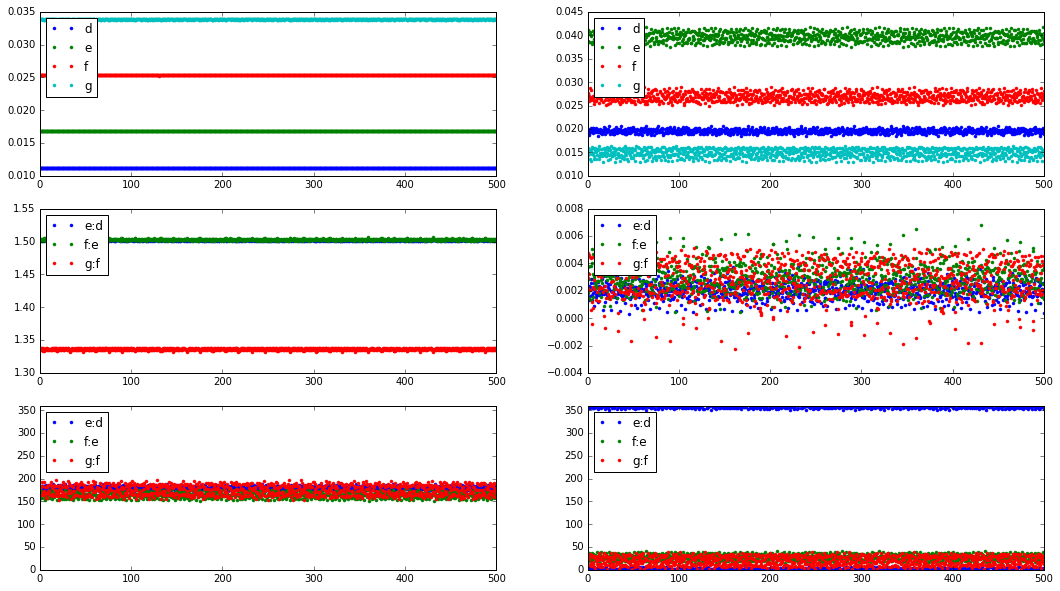

In [8]:
import numpy as np
labels = ['star', 'd', 'e', 'f', 'g']#['star', 'b', 'c', 'd', 'e', 'f', 'g']
resonances = [(3,2),(3,2),(4,3)]#[(4,3),(3,2),(3,2),(3,2),(4,3)]
plotsa(sa,resonances,labels);

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 7.49 s, sys: 0 ns, total: 7.49 s
Wall time: 7.5 s


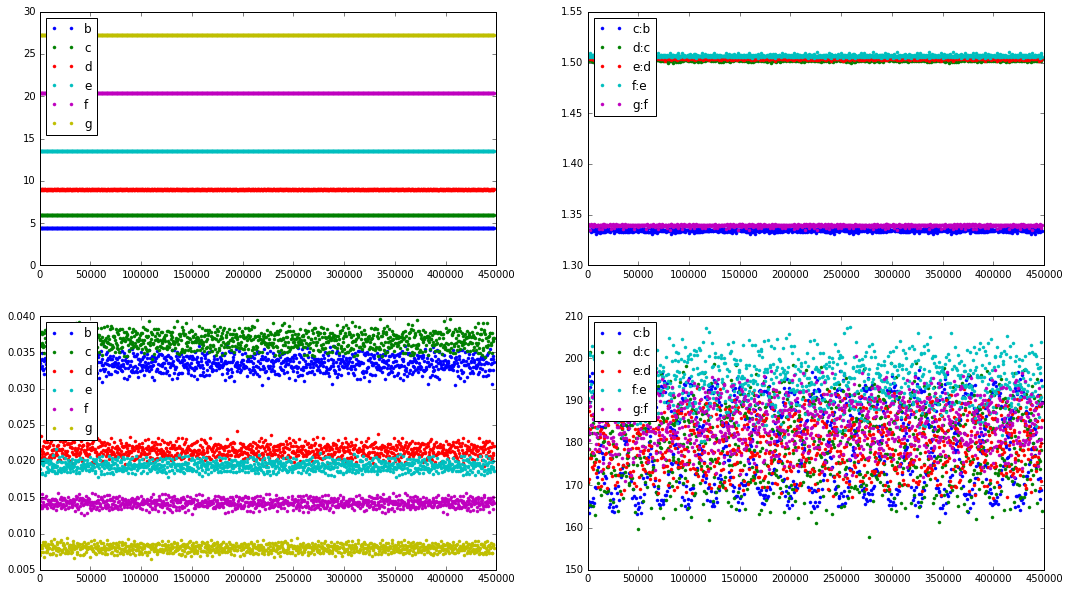

In [335]:
%%time
Nplanets = 6
t, e, P, pomega, longitude, Pratio, phi1, masses = [], [], [], [], [], [], [], []
for i in range(Nplanets+1):
    t.append([])
    e.append([])
    P.append([])
    pomega.append([])
    longitude.append([])
    Pratio.append([])
    phi1.append([])
    masses.append([])
    
sim.t = 0
integrate(sim, 1e6*ps[1].P, t, e, P, pomega, longitude, masses, Pratio, phi1, resonances)
plot(t,P,e,masses,Pratio,phi1);

In [579]:
def logsigmoid(tau0, tauf, T, t0, t): # assumes t=0 at beginning of transition
    tau0 = np.log(tau0)
    tauf = np.log(tauf)
    return np.exp(tau0 + (tauf-tau0)/(1.+np.exp(-10.*((t-t0)/T - 0.5))))

In [580]:
t0 = sim.t
taua0 = abs(ps[1].params["tau_a"])
taue0 = abs(ps[1].params["tau_e"])
tauef = 8.e7
T = taue0

Nout = 1000
pratio_2, phi1_2, e1_2, tau_e = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
times_2 = np.linspace(sim.t,sim.t+T,Nout)
for i, time in enumerate(times_2):
    tau_e[i] = logsigmoid(taue0, tauef, T, t0, time)
    ps[1].params["tau_e"] = -tau_e[i]
    ps[2].params["tau_e"] = -tau_e[i]
    ps[1].params["tau_a"] = taua0*(tau_e[i]/taue0) # keep ratio K constant
    
    sim.integrate(time)
    pratio_2[i] = ps[2].P/ps[1].P
    phi1_2[i] = wrap((p+q)*ps[2].l - p*ps[1].l - q*ps[1].pomega)
    e1_2[i] = ps[2].e

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


In [581]:
times = np.concatenate([times, times_2])
pratio = np.concatenate([pratio, pratio_2])
e1 = np.concatenate([e1, e1_2])
phi1 = np.concatenate([phi1, phi1_2])

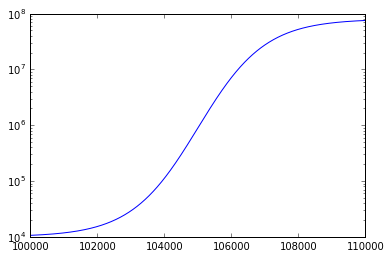

In [582]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(times_2, tau_e)
ax.set_yscale('log')
#ax.axhline((p+q)/p)

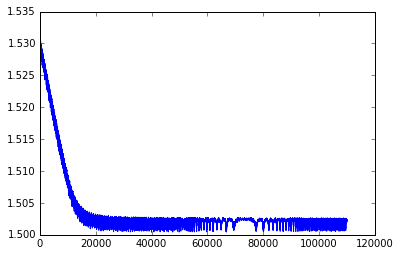

In [583]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(times, pratio)
ax.axhline((p+q)/p)

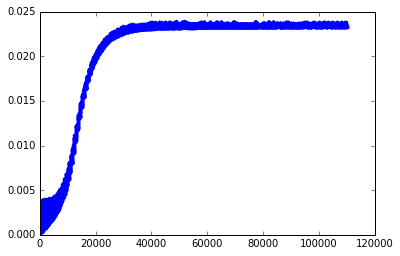

In [584]:
fig, ax = plt.subplots()
ax.plot(times, e1, '.')
#ax.set_xscale('log')
#ax.set_yscale('log')

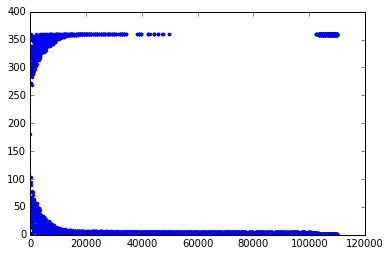

In [585]:
fig, ax = plt.subplots()
ax.plot(times, phi1, '.')